WSR Withanage
25004

In [1]:
# Core
import os, re, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Hugging Face dataset
from datasets import load_dataset

# Feature extraction & embeddings
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec, FastText

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Evaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    roc_curve,
    auc
)

# Model selection & curves
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.manifold import TSNE


/Users/sandunwithanage/Desktop/nlp-imdb/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset = load_dataset("imdb")

In [5]:
# Train/test split
train_df = pd.DataFrame(dataset["train"])
test_df  = pd.DataFrame(dataset["test"])

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()

Train shape: (25000, 2)
Test shape: (25000, 2)


,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


Preprocessin

In [6]:
# Download NLTK resources
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text, lemmatize=False):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    if lemmatize:
        tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sandunwithanage/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sandunwithanage/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


TF-IDF Baseline (Logistic Regression)

In [7]:
# Clean text (no lemmatization)
X_train_clean = train_df["text"].apply(lambda x: clean_text(x))
X_test_clean  = test_df["text"].apply(lambda x: clean_text(x))

In [8]:
# TF-IDF features
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=40000)
Xtr = tfidf.fit_transform(X_train_clean)
Xte = tfidf.transform(X_test_clean)

In [9]:
# Logistic Regression
clf = LogisticRegression(max_iter=2000, n_jobs=-1, solver="saga")
clf.fit(Xtr, train_df["label"])

y_pred = clf.predict(Xte)

print("📊 TF-IDF Logistic Regression:")
print(classification_report(test_df["label"], y_pred, digits=4))

📊 TF-IDF Logistic Regression:
              precision    recall  f1-score   support

           0     0.8890    0.8850    0.8870     12500
           1     0.8855    0.8894    0.8875     12500

    accuracy                         0.8872     25000
   macro avg     0.8872    0.8872    0.8872     25000
weighted avg     0.8872    0.8872    0.8872     25000



SVM (on TF-IDF)

In [10]:
clf_svm = LinearSVC()
clf_svm.fit(Xtr, train_df["label"])
y_pred_svm = clf_svm.predict(Xte)

print("📊 TF-IDF SVM:")
print(classification_report(test_df["label"], y_pred_svm, digits=4))

📊 TF-IDF SVM:
              precision    recall  f1-score   support

           0     0.8734    0.8882    0.8808     12500
           1     0.8863    0.8713    0.8787     12500

    accuracy                         0.8798     25000
   macro avg     0.8799    0.8798    0.8798     25000
weighted avg     0.8799    0.8798    0.8798     25000



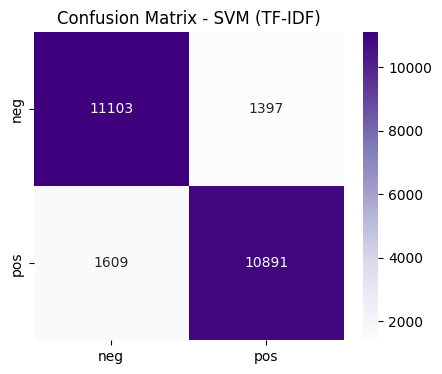

In [11]:
# Confusion Matrix
cm = confusion_matrix(test_df["label"], y_pred_svm)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["neg","pos"], yticklabels=["neg","pos"])
plt.title("Confusion Matrix - SVM (TF-IDF)")
plt.show()

Word2Vec Embeddings

In [12]:
# Tokenize
train_tokens = [clean_text(t).split() for t in train_df["text"]]
test_tokens  = [clean_text(t).split() for t in test_df["text"]]

In [13]:
# Train Word2Vec
w2v = Word2Vec(sentences=train_tokens, vector_size=200, window=5, min_count=2, workers=4, sg=1, epochs=10)

In [14]:
# Document embeddings (average of word vectors)
def doc_vector(tokens, model):
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

Xtr_w2v = np.vstack([doc_vector(t, w2v) for t in train_tokens])
Xte_w2v = np.vstack([doc_vector(t, w2v) for t in test_tokens])

In [15]:
# Train classifier
clf_w2v = LogisticRegression(max_iter=2000, n_jobs=-1, solver="saga")
clf_w2v.fit(Xtr_w2v, train_df["label"])
print("📊 Word2Vec Logistic Regression:")
print(classification_report(test_df["label"], clf_w2v.predict(Xte_w2v), digits=4))

📊 Word2Vec Logistic Regression:
              precision    recall  f1-score   support

           0     0.8536    0.8609    0.8572     12500
           1     0.8597    0.8523    0.8560     12500

    accuracy                         0.8566     25000
   macro avg     0.8566    0.8566    0.8566     25000
weighted avg     0.8566    0.8566    0.8566     25000



fastText Embeddings

In [17]:
# Train fastText
ft = FastText(sentences=train_tokens, vector_size=200, window=5, min_count=2, workers=4, sg=1, epochs=10)

Xtr_ft = np.vstack([doc_vector(t, ft) for t in train_tokens])
Xte_ft = np.vstack([doc_vector(t, ft) for t in test_tokens])

In [18]:
clf_ft = LogisticRegression(max_iter=2000, n_jobs=-1, solver="saga")
clf_ft.fit(Xtr_ft, train_df["label"])
print("📊 fastText Logistic Regression:")
print(classification_report(test_df["label"], clf_ft.predict(Xte_ft), digits=4))

📊 fastText Logistic Regression:
              precision    recall  f1-score   support

           0     0.8594    0.8650    0.8622     12500
           1     0.8641    0.8585    0.8613     12500

    accuracy                         0.8617     25000
   macro avg     0.8617    0.8617    0.8617     25000
weighted avg     0.8617    0.8617    0.8617     25000



ROC / AUC Curves

In [19]:
plt.figure(figsize=(7,6))

models = {
    "TF-IDF (LogReg)": (clf, Xte),
    "TF-IDF (SVM)": (clf_svm, Xte),
    "Word2Vec": (clf_w2v, Xte_w2v),
    "fastText": (clf_ft, Xte_ft),
}

<Figure size 700x600 with 0 Axes>

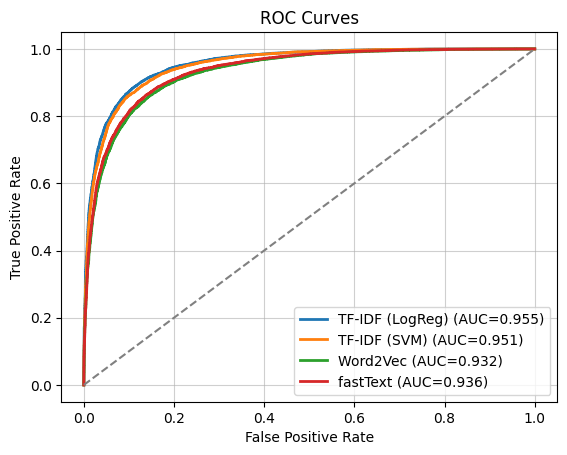

In [20]:
for name, (model, Xtest_) in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(Xtest_)[:,1]
    else:
        y_score = model.decision_function(Xtest_)
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())
    fpr, tpr, _ = roc_curve(test_df["label"], y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(); plt.grid(alpha=0.6)
plt.show()

Lemma vs No Lemma

In [22]:
# Lemmatized preprocessing
X_train_lemma = train_df["text"].apply(lambda x: clean_text(x, lemmatize=True))
X_test_lemma  = test_df["text"].apply(lambda x: clean_text(x, lemmatize=True))

In [23]:
tfidf_lemma = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=40000)
Xtr_lemma = tfidf_lemma.fit_transform(X_train_lemma)
Xte_lemma = tfidf_lemma.transform(X_test_lemma)

clf_lemma = LogisticRegression(max_iter=2000, n_jobs=-1, solver="saga")
clf_lemma.fit(Xtr_lemma, train_df["label"])

print("📊 TF-IDF (With Lemma):")
print(classification_report(test_df["label"], clf_lemma.predict(Xte_lemma), digits=4))

📊 TF-IDF (With Lemma):
              precision    recall  f1-score   support

           0     0.8865    0.8819    0.8842     12500
           1     0.8825    0.8870    0.8848     12500

    accuracy                         0.8845     25000
   macro avg     0.8845    0.8845    0.8845     25000
weighted avg     0.8845    0.8845    0.8845     25000



Learning Curve (TF-IDF LogReg)

In [24]:
train_sizes, train_scores, test_scores = learning_curve(
    clf, Xtr, train_df["label"],
    cv=5, scoring="accuracy", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    shuffle=True, random_state=42
)

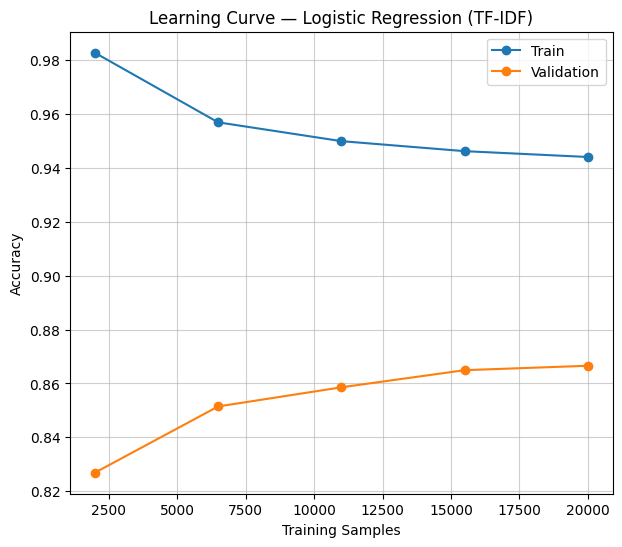

In [25]:
plt.figure(figsize=(7,6))
plt.plot(train_sizes, train_scores.mean(axis=1), "o-", label="Train")
plt.plot(train_sizes, test_scores.mean(axis=1), "o-", label="Validation")
plt.xlabel("Training Samples"); plt.ylabel("Accuracy")
plt.title("Learning Curve — Logistic Regression (TF-IDF)")
plt.legend(); plt.grid(alpha=0.6)
plt.show()

t-SNE Visualization (Comparison)

In [26]:
sample = test_df.sample(1500, random_state=42)
sample_tokens = [clean_text(t).split() for t in sample["text"]]

# Representations
X_sample_tfidf = tfidf.transform(sample["text"].apply(lambda x: clean_text(x))).toarray()
X_sample_w2v = np.vstack([doc_vector(t, w2v) for t in sample_tokens])
X_sample_ft  = np.vstack([doc_vector(t, ft)  for t in sample_tokens])



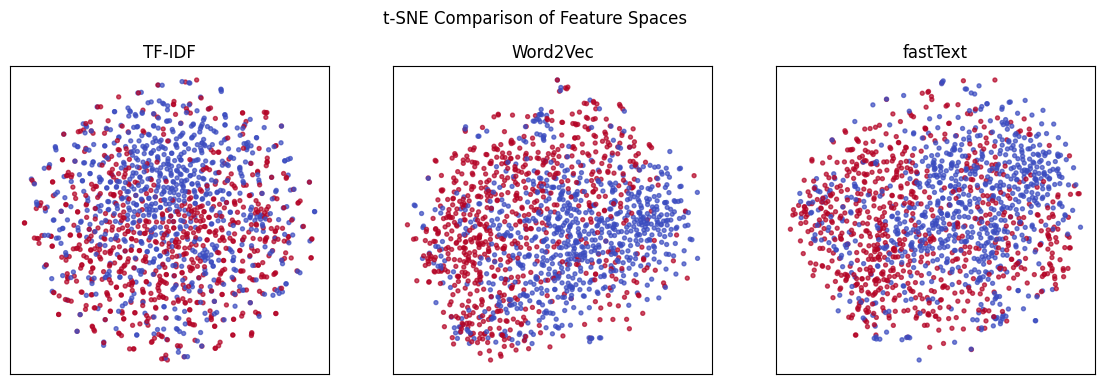

In [27]:
# Reduce & plot
fig, axes = plt.subplots(1,3, figsize=(14,4))
for ax, data, title in zip(
    axes,
    [X_sample_tfidf, X_sample_w2v, X_sample_ft],
    ["TF-IDF", "Word2Vec", "fastText"]
):
    XY = TSNE(n_components=2, random_state=42, max_iter=1000).fit_transform(data)
    ax.scatter(XY[:,0], XY[:,1], c=sample["label"], cmap="coolwarm", s=8, alpha=0.7)
    ax.set_title(title); ax.set_xticks([]); ax.set_yticks([])
fig.suptitle("t-SNE Comparison of Feature Spaces", y=1.02)
plt.show()

Final result

In [28]:
results = {
    "TF-IDF (LogReg)": {
        "accuracy": accuracy_score(test_df["label"], y_pred),
        "f1_macro": f1_score(test_df["label"], y_pred, average="macro"),
    },
    "TF-IDF (SVM)": {
        "accuracy": accuracy_score(test_df["label"], y_pred_svm),
        "f1_macro": f1_score(test_df["label"], y_pred_svm, average="macro"),
    },
    "Word2Vec": {
        "accuracy": accuracy_score(test_df["label"], clf_w2v.predict(Xte_w2v)),
        "f1_macro": f1_score(test_df["label"], clf_w2v.predict(Xte_w2v), average="macro"),
    },
    "fastText": {
        "accuracy": accuracy_score(test_df["label"], clf_ft.predict(Xte_ft)),
        "f1_macro": f1_score(test_df["label"], clf_ft.predict(Xte_ft), average="macro"),
    },
}
pd.DataFrame(results).T.round(4)


,accuracy,f1_macro
TF-IDF (LogReg),0.8872,0.8872
TF-IDF (SVM),0.8798,0.8798
Word2Vec,0.8566,0.8566
fastText,0.8617,0.8617


<Figure size 700x500 with 0 Axes>

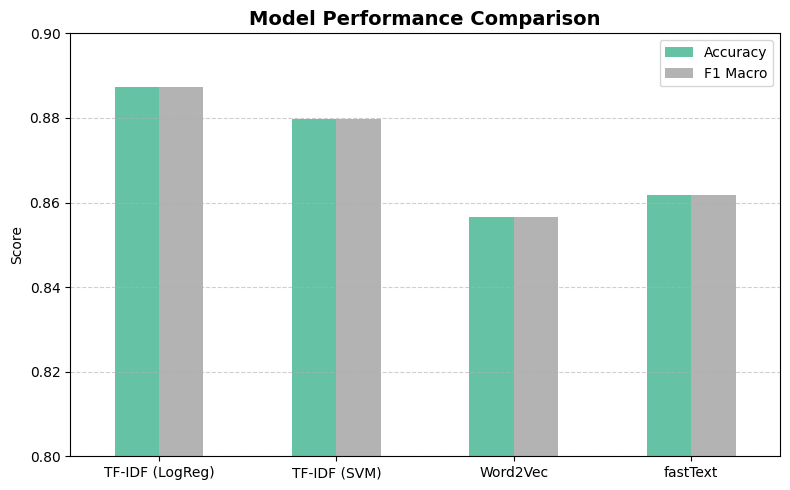

In [32]:
results_df = pd.DataFrame(results).T.round(4)

plt.figure(figsize=(7,5))
results_df[["accuracy","f1_macro"]].plot(
    kind="bar", figsize=(8,5), rot=0, colormap="Set2"
)
plt.ylim(0.80, 0.90)  # zoom in for clarity
plt.title("Model Performance Comparison", fontsize=14, weight="bold")
plt.ylabel("Score")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(["Accuracy","F1 Macro"])
plt.tight_layout()
plt.show()
